In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from ridge import Ridge_
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import inf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
predictor = 'Year'
target = 'Time'

In [3]:
df = pd.read_csv('olympics_100m.csv', sep=',')
X = df[predictor].values
y = df[target].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [5]:
# Centering and normalizing the data
x_mean = X_train.mean()
x_std = X_train.std()

# # scale the data
X_train = (X_train - x_mean) / x_std
X_train = X_train.reshape(len(X_train), 1)

X_test = (X_test - x_mean) / x_std
X_test = X_test.reshape(len(X_test), 1)

# X_val = (X_val - x_mean) / x_std
# X_val = X_val.reshape(len(X_val), 1)

In [6]:
poly = PolynomialFeatures(1)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
# X_val = poly.fit_transform(X_val)

In [7]:
lambda_values = [10**i for i in range(-20, -3)]
mae_errors = []
mse_errors = []
k = 5  # number of folds
k_fold = KFold(n_splits = k)

# check that k is not greater than the number of samples
if k > len(X_train):
    raise ValueError("Number of folds cannot be greater than number of samples")

for train_k, val_k in k_fold.split(X_train):

# for train_k, val_k in TimeSeriesSplit(n_splits=k).split(X_train):
    X_train_fold, X_val_fold = X_train[train_k], X_train[val_k]
    y_train_fold, y_val_fold = y_train[train_k], y_train[val_k]
    for l in lambda_values:
        # train the model with the current lambda value
        
        ridge_model = Ridge_(l)
        w = ridge_model.ridge_fit(X_train_fold, y_train_fold)

        # predict on the validation set
        pred = ridge_model.ridge_predict(X_val_fold)
        
        mae_e = mean_absolute_error(y_val_fold, pred)
        mse_e = mean_squared_error(y_val_fold, pred)
        mae_errors.append(mae_e)
        mse_errors.append(mse_e)

# calculate the average error for each lambda value across the k folds
avg_errors_mae = np.mean(np.array(mae_errors).reshape((k, len(lambda_values))), axis=0)  
avg_errors_mse = np.mean(np.array(mse_errors).reshape((k, len(lambda_values))), axis=0)

# select the lambda value with the lowest average error
best_l_mae = lambda_values[np.argmin(avg_errors_mae)] 
best_l_mse = lambda_values[np.argmin(avg_errors_mse)]

In [8]:
print(f"Best lambda values: considering MAE: {best_l_mae}, considering MSE: {best_l_mse}", )
best_l = best_l_mae if best_l_mae < best_l_mse else best_l_mse
best_l

Best lambda values: considering MAE: 0.0001, considering MSE: 1e-14


1e-14

In [9]:
# train the model with the best lambda value found
ridge_model = Ridge_(best_l)
w = ridge_model.ridge_fit(X_train, y_train)

# predict on the validation set
# pred_val = ridge_model.ridge_predict(X_val)
# mae_val = mean_absolute_error(y_val, pred_val)
# mse_val = mean_squared_error(y_val, pred_val)

# predict on the test set
pred_test = ridge_model.ridge_predict(X_test)
mae_test = mean_absolute_error(y_test, pred_test)
mse_test = mean_squared_error(y_test, pred_test)

mse_test

0.05148365684567089

In [10]:
# Create a DataFrame to store the metrics
# metrics = pd.DataFrame({
#     'Set': ['Validation', 'Test'],
#     'MAE': [mae_val, mae_test],
#     'MSE': [mse_val, mse_test],
# })
# metrics

In [11]:
print(f"Bias: {w[1]}, Weights: {w[0]}")

Bias: -0.4288885686768727, Weights: 10.431739130434782


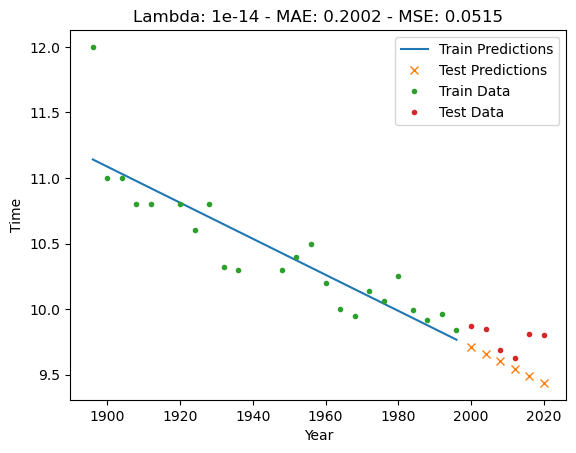

In [12]:
y_hat = ridge_model.ridge_predict(X_train)
plt.tight_layout()
plt.plot(X_train[:, 1]*x_std+x_mean, y_hat, label='Train Predictions')
plt.plot(X_test[:, 1]*x_std+x_mean, pred_test, 'x', label='Test Predictions')
plt.plot(X_train[:, 1]*x_std+x_mean, y_train, '.', label='Train Data')
plt.plot(X_test[:, 1]*x_std+x_mean, y_test, '.', label='Test Data')
plt.xlabel("Year")
plt.ylabel("Time")
plt.title(f"Lambda: {best_l} - MAE: {mae_test:.4f} - MSE: {mse_test:.4f}")
plt.legend()

In [13]:
# test with sklearn
ridge_model2 = Ridge(alpha=best_l)
ridge_model2.fit(X_train[:, 1].reshape(-1, 1), y_train)


sklearn_pred_test = ridge_model2.predict(X_test[:, 1].reshape(-1, 1))
# difference between our model predicions and sklearn ones
diff_test = pred_test - sklearn_pred_test

mae_test_skl = mean_absolute_error(sklearn_pred_test, pred_test)
mse_test_skl = mean_squared_error(sklearn_pred_test, pred_test)

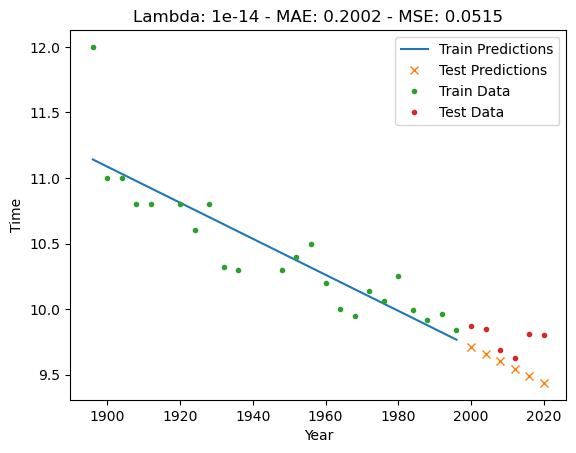

In [14]:
y_hat_sklearn = ridge_model2.predict(X_train[:, 1].reshape(-1, 1))
plt.plot(X_train[:, 1]*x_std+x_mean, y_hat_sklearn, label='Train Predictions')
plt.plot(X_test[:, 1]*x_std+x_mean, sklearn_pred_test, 'x', label='Test Predictions')
plt.plot(X_train[:, 1]*x_std+x_mean, y_train, '.', label='Train Data')
plt.plot(X_test[:, 1]*x_std+x_mean, y_test, '.', label='Test Data')
plt.xlabel("Year")
plt.ylabel("Time")
plt.title(f"Lambda: {best_l} - MAE: {mae_test:.4f} - MSE: {mse_test:.4f}")
plt.legend()

In [15]:
print(f"Sklearn Bias: {ridge_model2.coef_}, our model bias: {w[1]} --> difference: {ridge_model2.coef_ - w[1]},\n Sklearn Weights: {ridge_model2.intercept_}, our model weights: {w[0]} --> difference: {ridge_model2.intercept_ - w[0]}")

Sklearn Bias: [-0.42888857], our model bias: -0.4288885686768727 --> difference: [3.33066907e-16],
 Sklearn Weights: 10.431739130434783, our model weights: 10.431739130434782 --> difference: 1.7763568394002505e-15


In [16]:
# comparison with lasso
lasso_model = Lasso(alpha=best_l)
lasso_model.fit(X_train[:, 1].reshape(-1, 1), y_train)
lasso_model.intercept_, lasso_model.coef_
lasso_predictions = lasso_model.predict(X_test[:, 1].reshape(-1, 1))

In [17]:
mae_lasso = mean_absolute_error(sklearn_pred_test, lasso_predictions)
mse_lasso = mean_absolute_error(sklearn_pred_test, lasso_predictions)
print(f"MAE lasso: {mae_lasso}, MSE lasso: {mse_lasso}")
mae_lasso - mae_test_skl

MAE lasso: 1.9539925233402755e-14, MSE lasso: 1.9539925233402755e-14


1.7171449447535753e-14